In [1]:
import datetime
import math
import os
import numpy as np
import pandas as pd

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})

#https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/

In [2]:
def plot_measures(values,labels,titulo, x_rotation, fig_size=(8,8)):
        
    ind = np.arange(len(labels))  # the x locations for the groups
    width = 0.45  # the width of the bars

    fig, ax = plt.subplots(figsize=fig_size)
    rects1 = ax.bar(ind, values, width,color='SkyBlue')
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Conteos')
    ax.set_title(titulo)
    ax.set_xticks(ind)
    ax.set_xticklabels(labels,rotation = x_rotation)
    
    autolabel(rects1,ax, "center")
    plt.show()
    
def autolabel(rects, ax,xpos='center'):
    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                height, ha=ha[xpos], va='bottom')    

In [3]:
dataset_path = os.path.join('..','..','dataset','Series','Despacho','Despacho_0.xlsx')
dataset = pd.read_excel(dataset_path)

In [4]:
dataset.shape

(748392, 4)

In [5]:
dataset.columns

Index(['Fecha', 'Recurso', 'Código Agente', 'kWh'], dtype='object')

# Recursos

In [6]:
recursos_unicos = pd.unique(dataset['Recurso'])

In [7]:
'Cantidad de Recursos Unicos: {}'.format(len(recursos_unicos))

'Cantidad de Recursos Unicos: 18'

In [8]:
recursos_unicos_conteo = dataset.groupby('Recurso')['Fecha'].count()
recursos_unicos_conteo = recursos_unicos_conteo.sort_values(ascending=False)

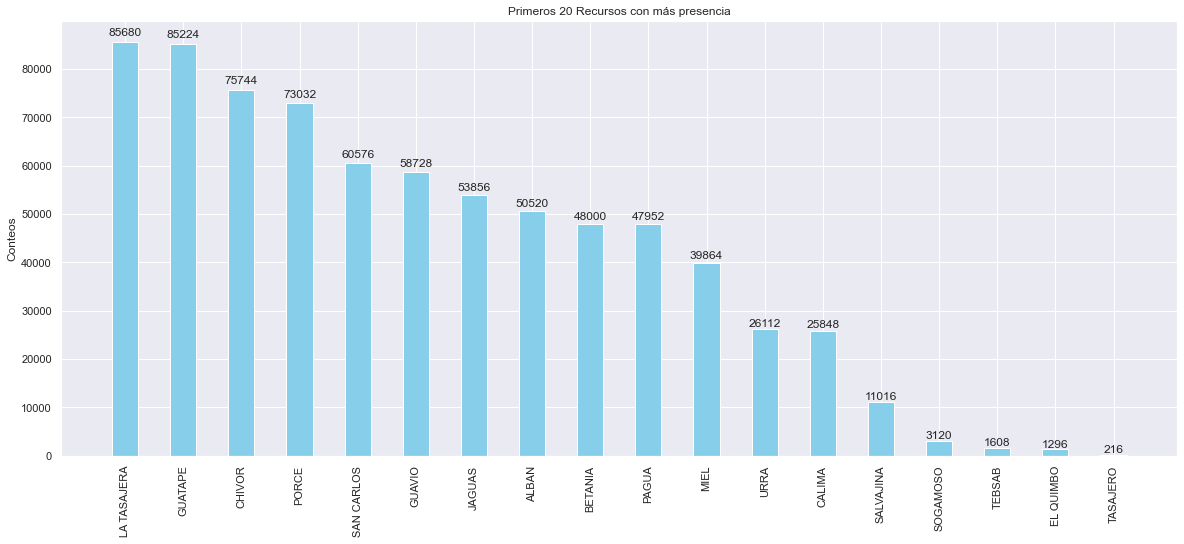

In [9]:
recursos_unicos_primeros = recursos_unicos_conteo[:20]
values = recursos_unicos_primeros.values
labels = recursos_unicos_primeros.index
plot_measures(values,labels,'Primeros 20 Recursos con más presencia',x_rotation=90,fig_size=(20,8))

# Visualización de los datos

In [10]:
def obtener_datos_por_recurso(data,nombre_recurso):
    
    datos_recurso = data[data['Recurso'] == nombre_recurso]
    datos_recurso = datos_recurso.copy()

    datos_recurso = datos_recurso.set_index('Fecha')
    
    datos_recurso['Año'] = datos_recurso.index.year
    datos_recurso['Mes'] = datos_recurso.index.month
    datos_recurso['Dia'] = datos_recurso.index.day_name()
    
    return datos_recurso

In [11]:
def grafico_comportamiento(datos):
    cols_plot = ['kWh']
    nombre_graficas = ['kWh']
    axes = datos[cols_plot].plot(alpha=0.8, linestyle='-', figsize=(15, 5), subplots=True)
    for ax,name in zip(axes,nombre_graficas):
        ax.set_ylabel(name)

In [12]:
def grafico_comportamiento_por_mes(datos):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5), sharex=True)
    
    sns.boxplot(data=datos, x='Mes', y='kWh', ax=ax)
    ax.set_title('kWh')

In [13]:
def grafico_filtrado_fecha(datos,fecha_min,fecha_max):
    ax = datos.loc[fecha_min:fecha_max, 'kWh'].plot(marker='o',linestyle='-',figsize=(15, 5))
    ax.set_ylabel('kWh');

In [14]:
def grafico_resampling_rolling_window(datos,fecha_min,fecha_max):
    cols_plot = ['kWh']
    datos_7d = datos[cols_plot].rolling(7, center=True).mean()

    fig, ax = plt.subplots(figsize=(15, 5))

    ax.plot(datos.loc[fecha_min:fecha_max, 'kWh'],
    marker='.', linestyle='-', linewidth=0.5, label='Diaria')

    ax.plot(datos_7d.loc[fecha_min:fecha_max, 'kWh'],linestyle='-', label='Media Movil 7-Días')

    ax.set_ylabel('kWh')
    ax.legend();

In [15]:
recurso = obtener_datos_por_recurso(dataset,nombre_recurso='PORCE')

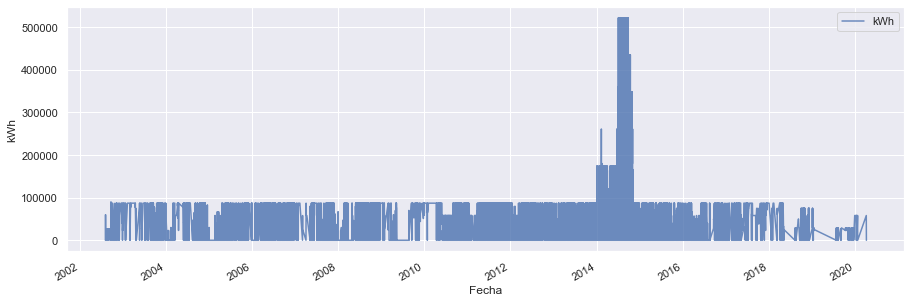

In [16]:
grafico_comportamiento(recurso)

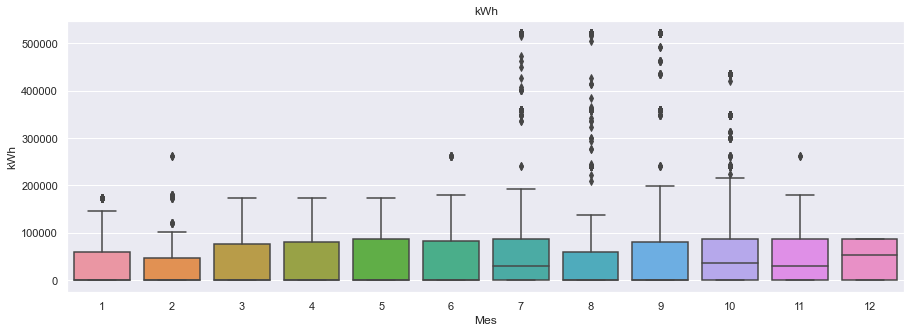

In [17]:
grafico_comportamiento_por_mes(recurso)

In [18]:
'Fecha Mínima {} - Fecha Máxima {}'.format(recurso.index.min(),recurso.index.max())

'Fecha Mínima 2002-08-09 00:00:00 - Fecha Máxima 2020-04-06 23:00:00'

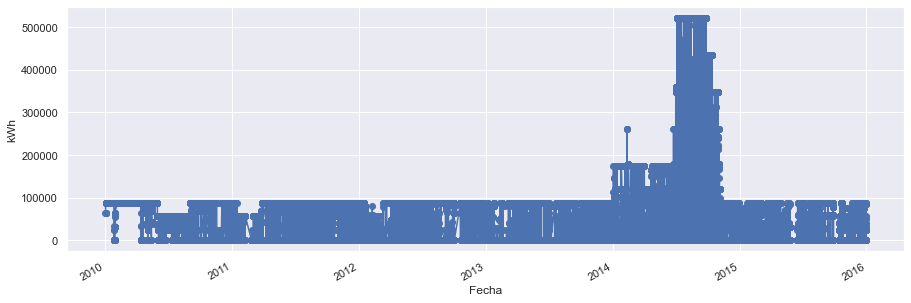

In [19]:
grafico_filtrado_fecha(datos=recurso,fecha_min='2010-01',fecha_max='2015-12')

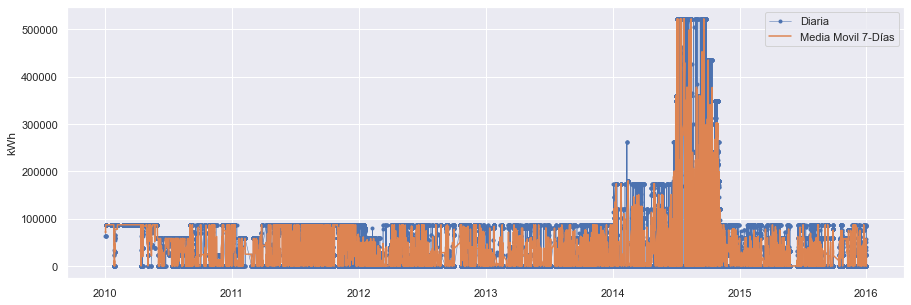

In [20]:
grafico_resampling_rolling_window(datos=recurso,fecha_min='2010-01',fecha_max='2015-12')